# TP2 - Algortimo estendido de Euclides
Grupo 05

    Eduardo André Silva Cunha A98980
    Gonçalo Emanuel Ferreira Magalhães A100084


# Problema

1. O algoritmo estendido de Euclides (EXA) aceita dois inteiros constantes  $\,a,b>0\,$  e devolve inteiros $r,s,t\,$ tais que  $\,a*s + b*t = r\,$  e  $\,r = \gcd(a,b)\,$. 
    Para além das variáveis $\,r,s,t\,$ o código requer 3 variáveis adicionais $\,r',s',t'\,$ que representam os valores de $\,r,s,t\,$ no “próximo estado”.


INPUT  a, b

assume  a > 0 and b > 0


r, r', s, s', t, t' = a, b, 1, 0, 0, 1


while r' != 0 {

q = r div r'

r, r', s, s', t, t' = r', r − q × r', s', s − q × s', t', t − q × t' 

}


OUTPUT r, s, t

1. Construa um FOTS usando BitVector de tamanho $n$ que descreva o comportamento deste programa: identifique as variáveis do modelo, o estado inicial e a relação de transição.
2. Considere estado de erro quando $\,r=0\,$ ou alguma das variáveis atinge o “overflow”.
Prove que o programa nunca atinge o estado de erro.
3. Prove que a relação de Bézout $\,$ $\,a*s + b*t = r\,$ é um invariante do algoritmo.

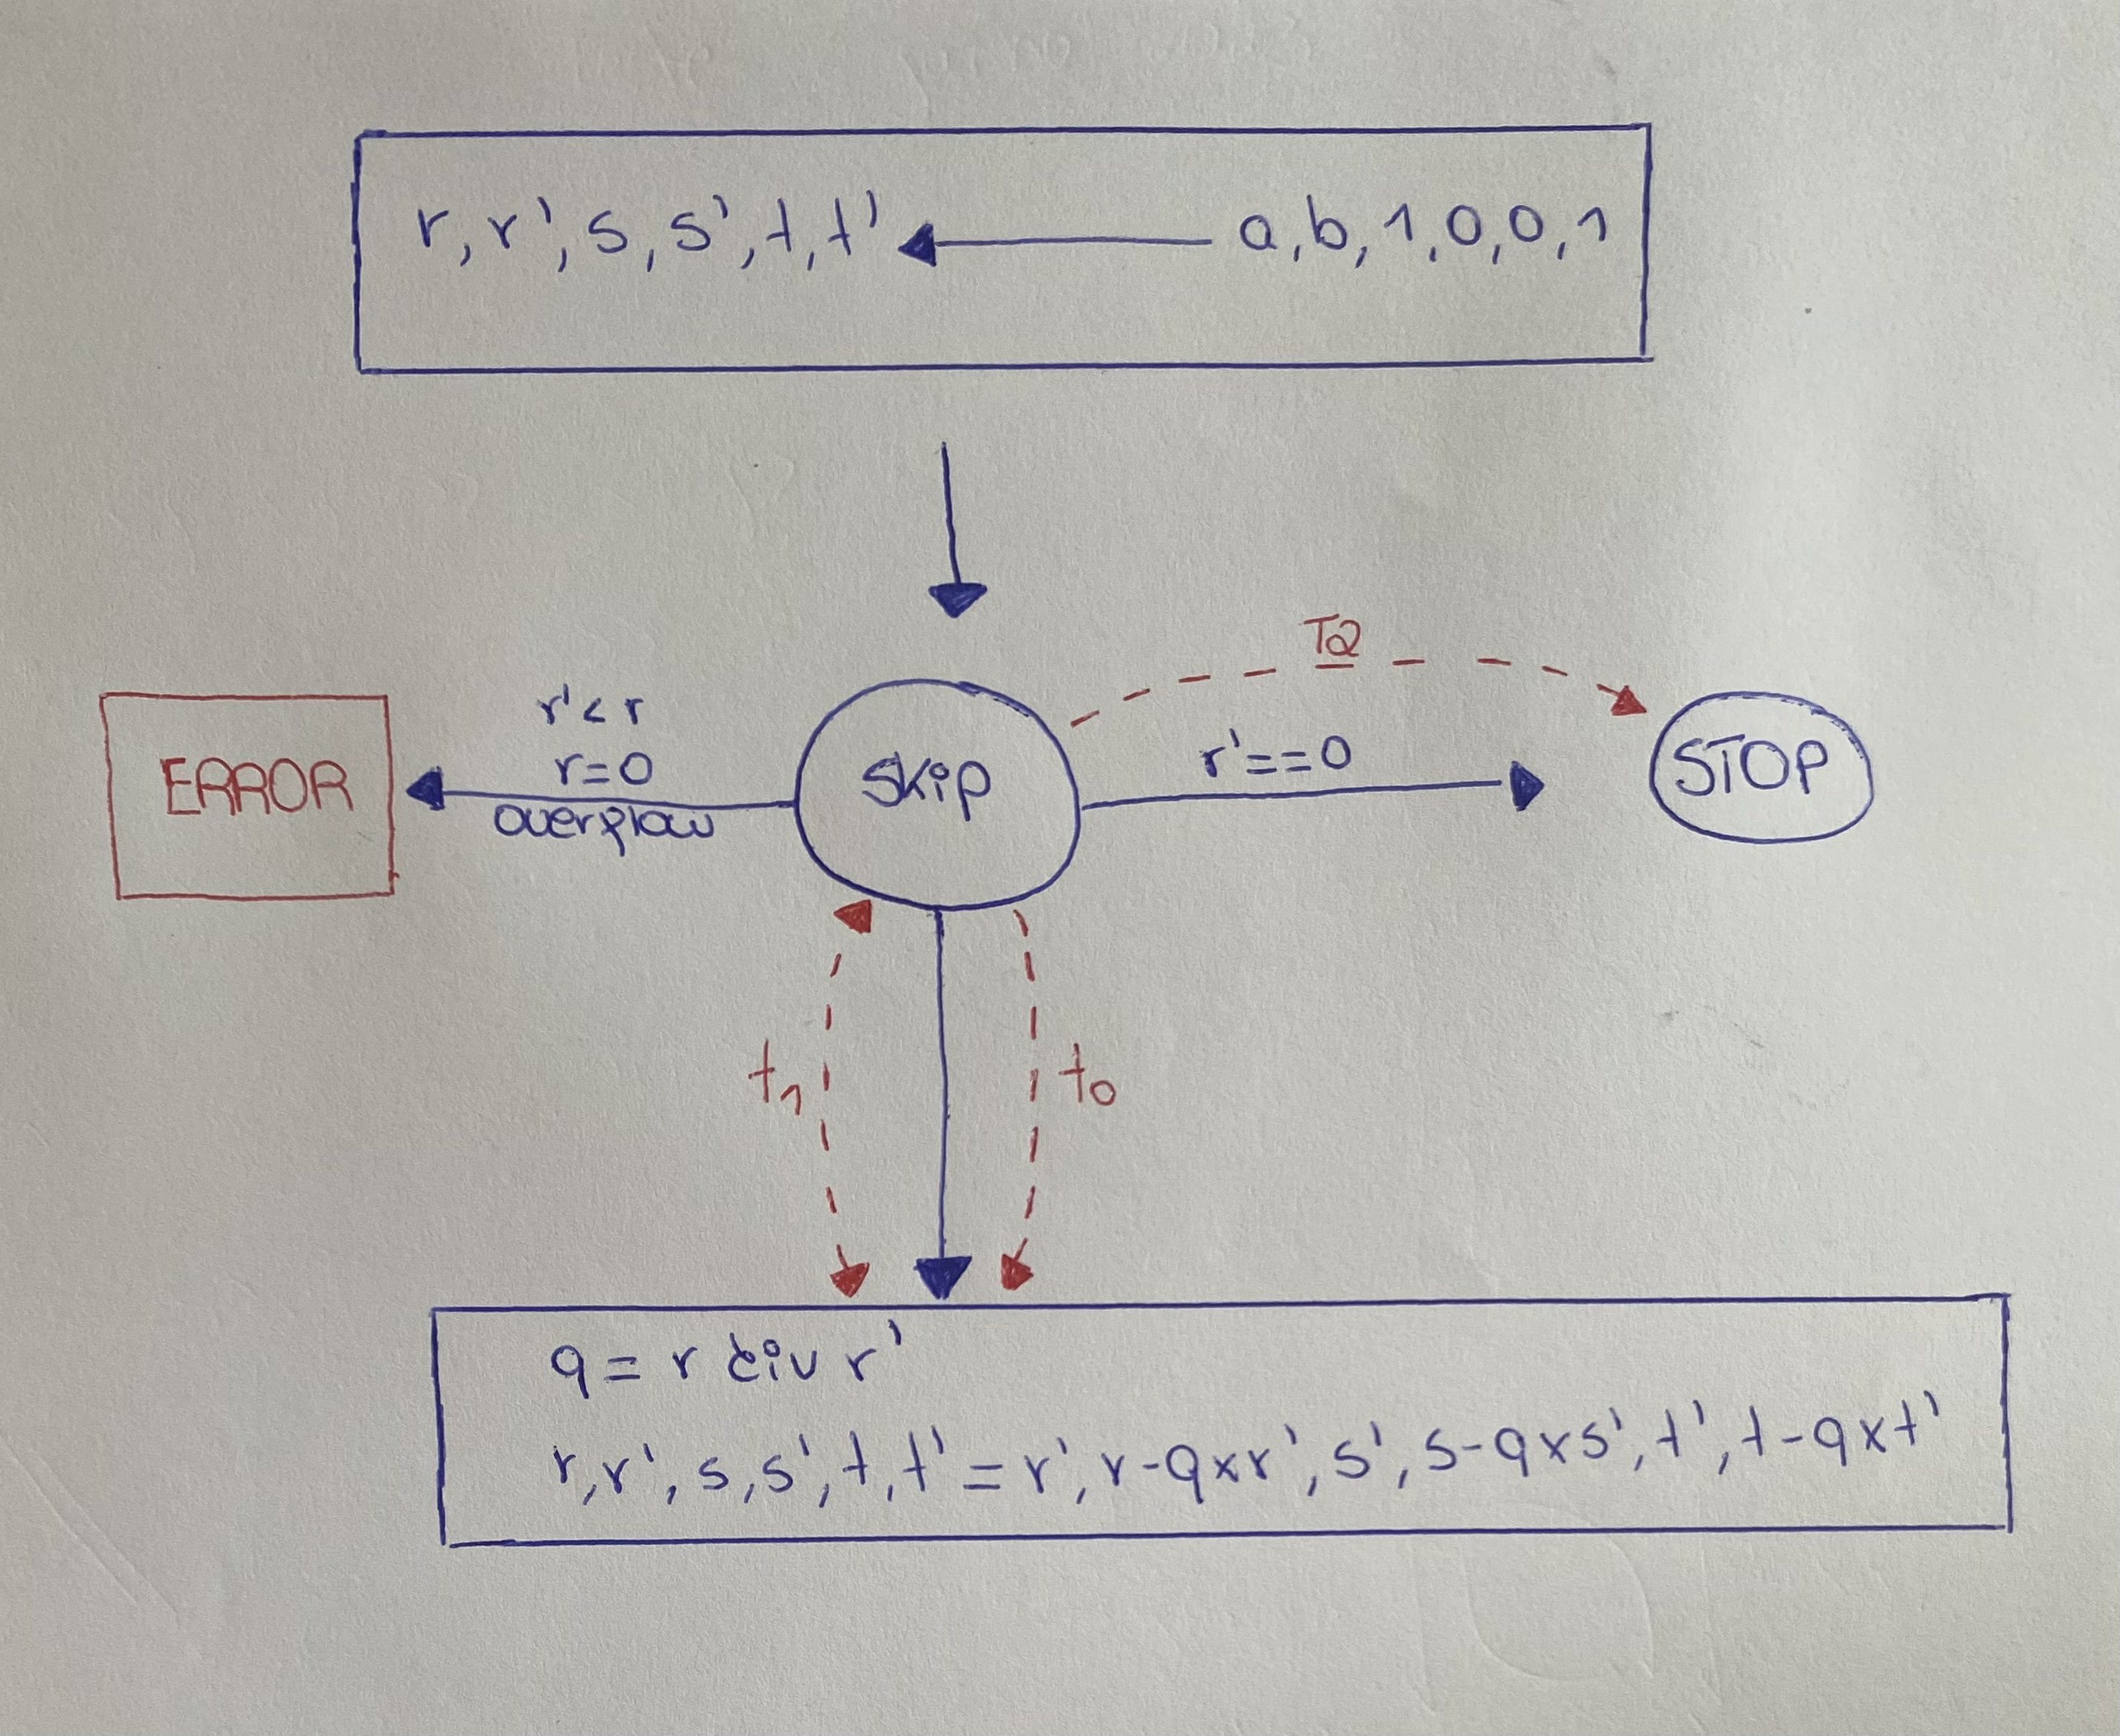

Import's utilizados

In [12]:
from z3 import *

Tamanho dos bitvectores

In [13]:
global n
n = 4

Variáveis de entrada

In [14]:
global a
a = 8

global b
b = 4

Função que calcula a divisão inteira entre 2 bitvectores

In [15]:
def div_inteira(bitvector_dividendo, bitvector_divisor, N):

    # ret como simbolo
    ret = BitVec("resultado", N)
    resto = BitVec("resto", N)

    solver = Solver() 

    # cond para divisor sempre diff de 0
    divisor_nao_zero = bitvector_divisor != 0 
    solver.add(divisor_nao_zero)

    # cond para resolver o problema da divisão
    solver.add(ret * bitvector_divisor + resto == bitvector_dividendo)

    # solve
    if solver.check() == sat:
        # se resolver então devolve o resultado, ret
        modelo = solver.model()
        res = modelo[ret]
        #res = int(str(modelo[ret]))
        return res
    else:
        # se não resolver retorna 0 (só mesmo em erro ig)
        return 0

Função que declara um dicicionário "state" com as variáveis de estado, que nos permite acede-las pelo nome

In [16]:
def declare(k):
    state = {}
    state["pc"] = Int("pc"+str(k)) # str(k) conveção
    state['r'] = BitVec("r"+str(k), n) # tamanho n, global
    state['r_linha'] = BitVec("r_linha"+str(k), n)
    state['s'] = BitVec("s"+str(k), n)
    state['s_linha'] = BitVec("s_linha"+str(k), n)
    state['t'] = BitVec("t"+str(k), n)
    state['t_linha'] = BitVec("t_linha"+str(k), n)
    return state

Função "init" garante o estado inicial

In [17]:
def init(state):
    return And((state["pc"] == 0),          # pc inicial = 0
               (state["r"] == a),           # r inicial = a, global
               (state["r_linha"] == b),     # r_linha inicial = b, global
               (state["s"] == 1),           # s inicial = 1
               (state["s_linha"] == 0),     # s_linha inicial = 0
               (state["t"] == 0),           # t inicial = 0
               (state["t_linha"] == 1))     # t_linha inicial = 1

Função que dados tês possíveis estados do programa, testa se é possível transitar de um estado para os outros.

In [18]:
"""def trans(curr, prox):
    # de fora pra dentro do ciclo
    # pc == 0 fora do ciclo
    t0 = And((curr["pc"]== 0), (prox["pc"] == 1), (prox['r'] == curr['r_linha']), # pc == 1 no proximo estado para indicar que está dentro do ciclo
             (prox['r_linha'] == curr['r'] - (div_inteira(curr['r'], curr['r_linha'], n)) * curr['r_linha']),
             (prox['s_linha'] == curr['s'] - (div_inteira(curr['r'], curr['r_linha'], n)) * curr['s_linha']),
             (prox['t_linha'] == curr['t'] - (div_inteira(curr['r'], curr['r_linha'], n)) * curr['t_linha']), (prox['s'] == curr['s_linha']), (prox['t'] == curr['t_linha']))
    
    # de dentro para dentro do ciclo
    # pc == 1 no proximo estado para indicar que está dentro do ciclo
    t1 = And((curr['pc'] == 1), (curr['r_linha'] != 0), (prox['pc'] == 1), (prox['r'] == curr['r_linha']), (prox['r_linha'] == curr['r'] - (div_inteira(curr['r'],curr['r_linha'],n)) * curr['r_linha']),
            (prox['s'] == curr['s_linha']), (prox['s_linha'] == curr['s'] - (div_inteira(curr['r'],curr['r_linha'],n)) * curr['s_linha']), 
            (prox['t'] == curr['t_linha']), (prox['t_linha'] == curr['t'] - (div_inteira(curr['r'],curr['r_linha'],n)) * curr['t_linha']))
    
    # de dentro pra fora do ciclo
    # pc == 2 no proximo estado para indicar que vai para um estado final
    t2 = And((curr['pc'] == 1), (curr['r_linha'] == 0), (prox['pc'] == 2),(prox['r'] == curr['r']), (prox['r_linha'] == curr['r_linha']), (prox['s'] == curr['s']), 
             (prox['s_linha'] == curr['s_linha']), (prox['t'] == curr['t']), (prox['t_linha'] == curr['t_linha']))
    
    # mantem tudo igual para ser possivel gerar o traço em varios passos
    t4 = And((curr['pc'] == 2),(prox['pc'] == 2),(curr['r_linha'] == 0), (prox['r'] == curr['r']), (prox['r_linha'] == curr['r_linha']), (prox['s'] == curr['s']), (prox['s_linha'] == curr['s_linha']), (prox['t'] == curr['t']), (prox['t_linha'] == curr['t_linha']))
    
    return Or(t0,t1,t2,t4)  """  

def trans(curr, prox):
    # de fora pra dentro do ciclo
    # pc == 0 fora do ciclo
    t0 = And((curr["pc"]== 0), (prox["pc"] == 1), (prox['r'] == curr['r_linha']), # pc == 1 no proximo estado para indicar que está dentro do ciclo
             (prox['r_linha'] == curr['r'] - (curr['r'] / curr['r_linha']) * curr['r_linha']),
             (prox['s_linha'] == curr['s'] - (curr['r'] / curr['r_linha']) * curr['s_linha']),
             (prox['t_linha'] == curr['t'] - (curr['r'] / curr['r_linha']) * curr['t_linha']), (prox['s'] == curr['s_linha']), (prox['t'] == curr['t_linha']))
    
    # de dentro para dentro do ciclo
    # pc == 1 no proximo estado para indicar que está dentro do ciclo
    t1 = And((curr['pc'] == 1), (curr['r_linha'] != 0), (prox['pc'] == 1), (prox['r'] == curr['r_linha']), (prox['r_linha'] == curr['r'] - (curr['r'] / curr['r_linha']) * curr['r_linha']),
            (prox['s'] == curr['s_linha']), (prox['s_linha'] == curr['s'] - (curr['r'] / curr['r_linha']) * curr['s_linha']), 
            (prox['t'] == curr['t_linha']), (prox['t_linha'] == curr['t'] - (curr['r'] / curr['r_linha']) * curr['t_linha']))
    
    # de dentro pra fora do ciclo
    # pc == 2 no proximo estado para indicar que vai para um estado final
    t2 = And((curr['pc'] == 1), (curr['r_linha'] == 0), (prox['pc'] == 2),(prox['r'] == curr['r']), (prox['r_linha'] == curr['r_linha']), (prox['s'] == curr['s']), 
             (prox['s_linha'] == curr['s_linha']), (prox['t'] == curr['t']), (prox['t_linha'] == curr['t_linha']))
    
    # mantem tudo igual para ser possivel gerar o traço em varios passos
    t4 = And((curr['pc'] == 2),(prox['pc'] == 2),(curr['r_linha'] == 0), (prox['r'] == curr['r']), (prox['r_linha'] == curr['r_linha']), (prox['s'] == curr['s']), (prox['s_linha'] == curr['s_linha']), (prox['t'] == curr['t']), (prox['t_linha'] == curr['t_linha']))
    
    return Or(t0,t1,t2,t4) 
    

Função que gera um possível traço de execução do programa para k passos.

In [19]:
def gera_traco(declare, init, trans, k):
    # Cria um objeto Solver
    s = Solver()

    trace = [declare(i) for i in range(k)]

    # Adiciona a condição inicial à lista de restrições
    s.add(init(trace[0]))
    
    # Adiciona as transições à lista de restrições
    for i in range(k - 1):
        s.add(trans(trace[i], trace[i + 1]))

    # Garantir que no ultimo estado pc == 2 sempre, ou seja terminou o ciclo
    #s.add(trace[k-1]['pc'] == 2)

    # Verifica se é resolvivel
    if s.check() == sat:
        # Se as restrições forem satisfeitas, obtemos um modelo
        m = s.model()
        for i in range(k): # para todos os "tracos"
            # Imprime o passo atual
            print("Passo:", i)
            for var in trace[i]: # imprime cada variavel no traço[i]
                print("\t",var, "=", m[trace[i][var]])
            print("-------------------------")
    else:
        # Se as restrições não forem satisfeitas, imprime uma mensagem de erro
        print("Não foi possível gerar o traço.\n")



Execução:

In [20]:
gera_traco(declare,init,trans,5)

Passo: 0
	 pc = 0
	 r = 8
	 r_linha = 4
	 s = 1
	 s_linha = 0
	 t = 0
	 t_linha = 1
-------------------------
Passo: 1
	 pc = 1
	 r = 4
	 r_linha = 0
	 s = 0
	 s_linha = 1
	 t = 1
	 t_linha = 2
-------------------------
Passo: 2
	 pc = 2
	 r = 4
	 r_linha = 0
	 s = 0
	 s_linha = 1
	 t = 1
	 t_linha = 2
-------------------------
Passo: 3
	 pc = 2
	 r = 4
	 r_linha = 0
	 s = 0
	 s_linha = 1
	 t = 1
	 t_linha = 2
-------------------------
Passo: 4
	 pc = 2
	 r = 4
	 r_linha = 0
	 s = 0
	 s_linha = 1
	 t = 1
	 t_linha = 2
-------------------------


Prova que o programa nunca atinge estado de erro

In [21]:
def testa_prop_1(declare, init, trans, K):
    s = Solver()
    trace = [declare(i) for i in range(K)]

    s.add(init(trace[0]))

    # Propriedade: r não é 0 em nenhum estado e r é sempre >= que r_linha
    for i in range(K):
        s.add(trace[i]['r'] != 0)

    for i in range(K):
        s.add(trace[i]['r'] >=  trace[i]['r_linha'])

    for i in range(K - 1):
        # Adicione as transições
        s.add(trans(trace[i], trace[i+1]))

    if s.check() == sat:
        print("Propriedade violada em um estado do traço.")
    else:
        print("Propriedade mantida em todos os estados do traço.")


testa_prop_1(declare, init, trans, 10)

Propriedade mantida em todos os estados do traço.


Função que garante se a relação de Bézout é mantida em todos os estados de um traço

In [22]:
def prova_relacao_bezout(K):
    s = Solver()
    trace = [declare(i) for i in range(K)]

    s.add(init(trace[0]))

    # Adiciona as transições
    for i in range(K - 1):
        s.add(trans(trace[i], trace[i + 1]))

    # Verifica se a relação de Bézout é mantida em todos os estados do traço
    for i in range(K):
        bezout = a * trace[i]['s'] + b * trace[i]['t'] == trace[i]['r']
        # Adiciona a negação da expressão como uma restrição
        s.add(Not(bezout))

    # Como foi usada a negação, se houver solução é porque não satisfaz a condição
    if s.check() == sat:
        print("A relação de Bézout não é um invariante do algoritmo.")
    else:
        # Se a verificação retornar "unsat", a relação de Bézout é porque mantida em todos os estados do traço
        print("A relação de Bézout é um invariante do algoritmo.")


prova_relacao_bezout(10)


A relação de Bézout é um invariante do algoritmo.
